# Modeling COVID-19 Outcomes for Students, Essential Campus Workers, and Surrounding Community Under Different Reopening Scenarios at Stanford

Ross Alexander, Tejas Athni, Ryan Crowley, Adonis Rubio 



In [1]:
### Set-up and libraries import ###

import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec

from scipy.integrate import odeint
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from lmfit import minimize, Parameters 

current = os.getcwd()
filename = os.path.basename(current)[:-3]
os.chdir("C:/Users/tejas") 


In [6]:
### Initialize functions to extract COVID-19 case data from the New York Times dashboard ###

def LoadData():
    url='https://github.com/nytimes/covid-19-data/raw/master/us-states.csv'
    df_covid19us = pd.read_csv(url).sort_values(['state','date'])     #, index_col=['data', 'state', 'fips', 'cases','deaths']
    
    #Save copy
    today = datetime.datetime.now()
    if today.hour < 12:
        h = "00"
    else:
        h = "12"
    path2save = "data_backup/SaveCopies/" + today.strftime('%Y%m%d')+ h
    Today_str = today.strftime('%Y%m%d')+ h
    if not os.path.exists(path2save):
        os.makedirs(path2save)
    
    df_covid19us.to_csv(path2save+'/ConfirmedCases.csv')
    
    return df_covid19us


def getData_US(df_covid19us,ctr,End_time,Start_time,window):
   
    dates = df_covid19us.date
    Time_series = pd.to_datetime( df_covid19us['date'] )
    filtered_df = df_covid19us[(Time_series >= Start_time) & (Time_series <= End_time)] 
    df_state = filtered_df.loc[filtered_df.state == ctr]
    Cases = df_state['cases'].to_numpy()
    NewCases = np.diff(Cases)
    NewCases_smooth = movingaverage(NewCases,window)
    
    return Cases, NewCases, NewCases_smooth



### Unused but potentially useful functions below ###

def LoadStoredData(Timestr):

    path2load = "data_backup/SaveCopies/" + Timestr
    df_covid19us = pd.read_csv(path2load)
    
    return df_covid19us


def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


def getData_Own(Cases,window):
   
    NewCases = np.diff(Cases)
    NewCases_smooth = movingaverage(NewCases,window)
    
    return Cases, NewCases, NewCases_smooth


In [28]:
### Load COVID-19 data from NYT dashboard ###

states_names = ["Alabama","Alaska","Arizona","Arkansas",
               "California","Colorado","Connecticut","Delaware",
               "Florida","Georgia","Hawaii","Idaho","Illinois",
               "Indiana","Iowa","Kansas","Kentucky","Louisiana",
               "Maine","Maryland","Massachusetts","Michigan",
               "Minnesota","Mississippi","Missouri","Montana",
               "Nebraska","Nevada","New Hampshire","New Jersey",
               "New Mexico","New York","North Carolina","North Dakota",
               "Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
               "South Carolina","South Dakota","Tennessee","Texas",
               "Utah","Vermont","Virginia","Washington","West Virginia",
               "Wisconsin","Wyoming","International, PR, Guam"]


# Initialize parameters of interest for data-pulling
Tmax = 297
window = 297
Start_time = pd.to_datetime( datetime.date(2020,1,20))
End_time = Start_time + pd.Timedelta(pd.offsets.Day(Tmax))
time_full = pd.date_range(start=Start_time, end=End_time)


# Create an array with each state's population
term_locations = pd.read_csv('term_locations_formatted.csv')
term_locations[['State','Population']]


# Extract incoming Year 1 & 2 students, and source/home state population
incoming_students = np.asarray(term_locations["UG_Year1,2"])
states_population = np.asarray(term_locations["Population"])


# Seed initial SEIR_0 values
S_0_source = []
E_0_source = []
I_0_source = []
R_0_source = []

S_0_campus_leave = []
E_0_campus_leave = []
I_0_campus_leave = []
R_0_campus_leave = []

S_0_campus_stay = []
E_0_campus_stay = []
I_0_campus_stay = []
R_0_campus_stay = []

S_0_intl = []
E_0_intl = []
I_0_intl = []
R_0_intl = []


# Parameters
A = 2.5
C = 6.5


for i in range(0,50): 
    df_covid19us = LoadData()
    Cases, NewCases, NewCases_smooth  = getData_US(df_covid19us, states_names[i], End_time, Start_time, window)
    
    I_0_source.append(((Cases[len(Cases)-2]-Cases[len(Cases)-9])/states_population[i]) * incoming_students[i])
    E_0_source.append((A/C) * I_0_source[i])
    R_0_source.append((Cases[len(Cases)-16]/states_population[i]) * incoming_students[i])
    S_0_source.append(incoming_students[i] - I_0_source[i] - E_0_source[i] - R_0_source[i])
    
    

# Seed SEIR_0 values for students on campus this quarter and leaving for winter break

wb_leave = 5650 * 0.5

for i in range(4,5): 
    df_covid19us = LoadData()
    Cases, NewCases, NewCases_smooth  = getData_US(df_covid19us, states_names[i], End_time, Start_time, window)
    I_0_campus_leave.append(((Cases[len(Cases)-2]-Cases[len(Cases)-9])/states_population[i]) * wb_leave)
    E_0_campus_leave.append((A/C) * I_0_campus_leave[0])
    R_0_campus_leave.append((Cases[len(Cases)-16]/states_population[i]) * wb_leave)
    S_0_campus_leave.append(wb_leave - I_0_campus_leave[0] - E_0_campus_leave[0] - R_0_campus_leave[0])
    
    

# Seed SEIR_0 values for students on campus this quarter and remaining for winter break

wb_remain = 5650 * 0.5
    
campus_population = 5625
campus_cumulative_yesterday = 60
campus_cumulative_oneWeekAgo = 50
campus_cumulative_twoWeeksAgo = 47

I_0_campus_stay.append(((campus_cumulative_yesterday - campus_cumulative_oneWeekAgo)/campus_population) * wb_remain)
E_0_campus_stay.append((A/C) * I_0_campus_stay[0])
R_0_campus_stay.append((campus_cumulative_twoWeeksAgo/campus_population) * wb_remain)
S_0_campus_stay.append(wb_remain - I_0_campus_stay[0] - E_0_campus_stay[0] - R_0_campus_stay[0])



# Seed SEIR_0 values for students coming from international locations

world_population = 7800000000
intl_cumulative_yesterday = 52127000
intl_cumulative_oneWeekAgo = 48112000
intl_cumulative_twoWeeksAgo = 45015000

I_0_intl.append(((intl_cumulative_yesterday - intl_cumulative_oneWeekAgo)/world_population) * incoming_students[50])
E_0_intl.append((A/C) * I_0_intl[0])
R_0_intl.append((intl_cumulative_twoWeeksAgo/world_population) * incoming_students[50])
S_0_intl.append(incoming_students[50] - I_0_intl[0] - E_0_intl[0] - R_0_intl[0])

  

In [29]:
# Print output all of the SEIR_0 values

print("S_0_source Seed: ",sum(S_0_source))
print("E_0_source Seed: ",sum(E_0_source))
print("I_0_source Seed: ",sum(I_0_source))
print("R_0_source Seed: ",sum(R_0_source))
source_total = sum(S_0_source) + sum(E_0_source) + sum(I_0_source) + sum(R_0_source) 
print("Source total: ",source_total)

print("S_0_campus_leave Seed: ",sum(S_0_campus_leave))
print("E_0_campus_leave Seed: ",sum(E_0_campus_leave))
print("I_0_campus_leave Seed: ",sum(I_0_campus_leave))
print("R_0_campus_leave Seed: ",sum(R_0_campus_leave))
campus_leave_total = sum(S_0_campus_leave) + sum(E_0_campus_leave) + sum(I_0_campus_leave) + sum(R_0_campus_leave)
print("Campus leave total: ",campus_leave_total)

print("S_0_campus_stay Seed: ",sum(S_0_campus_stay))
print("E_0_campus_stay Seed: ",sum(E_0_campus_stay))
print("I_0_campus_stay Seed: ",sum(I_0_campus_stay))
print("R_0_campus_stay Seed: ",sum(R_0_campus_stay))
campus_stay_total = sum(S_0_campus_stay) + sum(E_0_campus_stay) + sum(I_0_campus_stay) + sum(R_0_campus_stay)
print("Campus stay total: ",campus_stay_total)

print("S_0_campus_intl Seed: ",sum(S_0_intl))
print("E_0_campus_intl Seed: ",sum(E_0_intl))
print("I_0_campus_intl Seed: ",sum(I_0_intl))
print("R_0_campus_intl Seed: ",sum(R_0_intl))
intl_total = sum(S_0_intl) + sum(E_0_intl) + sum(I_0_intl) + sum(R_0_intl)
print("International total: ",intl_total)

# Calculating the total SEIR_0 values with source, campus stay, campus leave, and international aggregated
S_0_total = sum(S_0_source) + sum(S_0_campus_leave) + sum(S_0_campus_stay) + sum(S_0_intl)
E_0_total = sum(E_0_source) + sum(E_0_campus_leave) + sum(E_0_campus_stay) + sum(E_0_intl)
I_0_total = sum(I_0_source) + sum(I_0_campus_leave) + sum(I_0_campus_stay) + sum(I_0_intl)
R_0_total = sum(R_0_source) + sum(R_0_campus_leave) + sum(R_0_campus_stay) + sum(R_0_intl)

print("S_0_total Seed: ",S_0_total)
print("E_0_total Seed: ",E_0_total)
print("I_0_total Seed: ",I_0_total)
print("R_0_total Seed: ",R_0_total)


print("Total Incoming Students for Winter Quarter: ",(S_0_total + E_0_total + I_0_total + R_0_total))


S_0_source Seed:  2562.733103940491
E_0_source Seed:  2.122373160783477
I_0_source Seed:  5.518170218037038
R_0_source Seed:  65.62635268068686
Source total:  2635.9999999999986
S_0_campus_leave Seed:  2754.5889432259205
E_0_campus_leave Seed:  1.2339808601271796
I_0_campus_leave Seed:  3.2083502363306664
R_0_campus_leave Seed:  65.96872567762132
Campus leave total:  2825.0
S_0_campus_stay Seed:  2794.441709401709
E_0_campus_stay Seed:  1.9316239316239316
I_0_campus_stay Seed:  5.022222222222222
R_0_campus_stay Seed:  23.604444444444443
Campus stay total:  2825.0
S_0_campus_intl Seed:  324.8797726331361
E_0_campus_intl Seed:  0.06473890532544378
I_0_campus_intl Seed:  0.16832115384615384
R_0_campus_intl Seed:  1.8871673076923077
International total:  327.0
S_0_total Seed:  8436.643529201257
E_0_total Seed:  5.352716857860032
I_0_total Seed:  13.917063830436081
R_0_total Seed:  157.08669011044492
Total Incoming Students for Winter Quarter:  8613.0


----------------------------------

EVERYTHING BELOW THS POINT IS OLD CODE FROM CLASS. can modify this for quarantine assay, though!!

-----------------------------------

As you can see, the table has 51 rows for the 50 states plus the federal district of Columbia (Washington, D.C.). For each location, it gives us

- the **total population**
- the normalized values for the compartments **S,E,I and R at a specific point in time**
- the **reproduction number R(t)**
- the **contact rate beta**

All of these model parameters come from fitting our SEIR model to case data from all states up to a specific time point (here beginning of July) and we will use them as our start values and model parameters in this notebook.

The last column contains **fictional passenger data** we created for the purpose of this notebook exercise.
How do we interpret this passenger data? Let's say we are interested in the disease dynamics in California. The information from the last column would then mean that over the course of one year (365 days),  𝑥  people are traveling to California from the respective other locations. For example, we would have 209205 passengers traveling from Arizona to California.

We can relate what we have here with graph theory where, for instance, susceptible population evolves in time as follows,
$\dot{S}_i = - \sum_j{\vartheta L_{ij} S_j - \beta S_i I_i}$. 
where $i,j= Alabama, Alaska ... Wyoming$. 
Incoming passengers data in our table correspond to $- \vartheta L_{ij}$ in the equation above, where $i$ is the state we consider and $j= Alabama, Alaska ... Wyoming$. So, we have the information from only the row $i$ of transport matrix $L_{ij}$.

For the purpose of this exercise, we will assume that this fictional incoming passenger data stays the same whether our region of interest is California or Texas or Utah. Even though in real life that is obviously not true.

In the next cell, we are saving the incoming passenger data and the contact rates beta for every state in numpy arrays (vectors). In addition, we are calculating the expected number of incoming infectious passengers for each state, so that we can implement selective quarantine strategies.  

In [6]:
# incoming passenger data 
A_all = df_summ['UG_Year1,2'].to_numpy()
#calculate the incoming infectious as I_0*Incoming_passenger
df_summ['UG_Year1,2']= df_summ['I_0'].mul(df_summ['UG_Year1,2'])
# contact rates
fb = df_summ['beta'].to_numpy()
# Number of locations
nodes = len(A_all)

Let's have a look at what our distribution of infectious passengers from the different locations looks like.

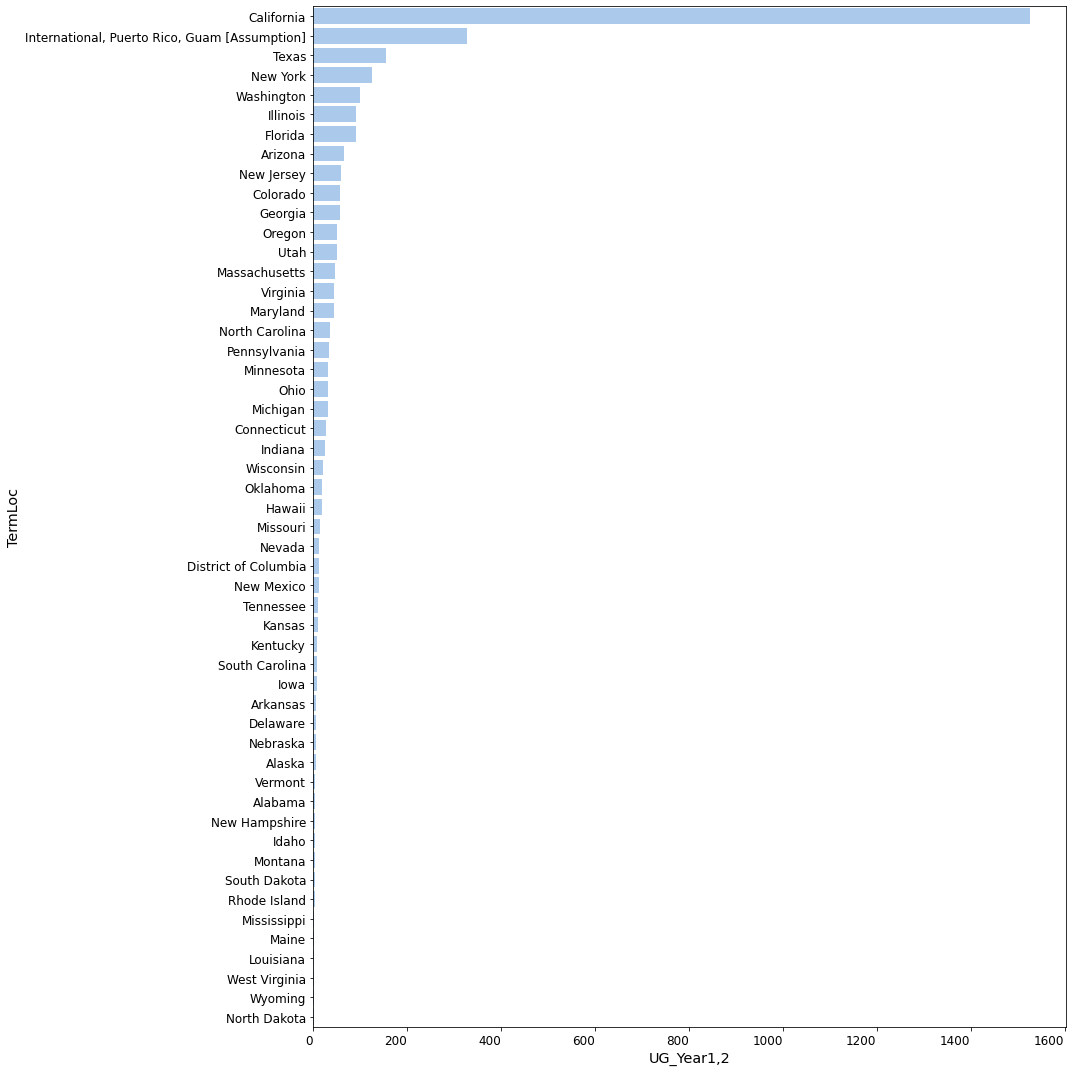

In [11]:
Label = 'UG_Year1,2'
df_pass = df_summ.sort_values(by=[Label], ascending=False)
#Plot
f, ax = plt.subplots(figsize=(15, 15)) 
sns.set_color_codes("pastel")
sns.barplot(x=Label, y="TermLoc", data=df_pass,
            label="Total", color="b")

#ax.axvline(df_summ['UG_Year1,2'].mean(), lw=4, ls='--', color='r')
# show_values_on_bars(ax, "h", 0.3)

plt.ylabel("TermLoc", fontsize='x-large')
plt.xlabel(Label, fontsize='x-large')
plt.xticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.tight_layout()



Next, we will define the settings for the forecasting in our region of interest. 
- As always, we need to define a time increment `dt` for the explicit integration scheme of our ODEs
- `Tmax` defines how far into the future we want to predict
- `idx` defines which state is our region of interest. Check in the table above which state has which index.
- `Flag_Iso` is a flag that can be set to either true or false depending on whether we want to apply quarantine to all incoming passengers (`Flag_iso=False`) or only to passengers from 'high-risk' states (`Flag_Iso=True`).


- `Af`, `Cf`, `fa` and `fc` are the disease-specific model parameters we are assuming to be the same for all states
- `fb[idx]` determines the contact rate we are using for forecasting in our location of interest. 
> - we can either keep this at the value `beta` from the table which came from fitting the SEIR model to data from beginning of July
> - or we can prescribe different values of `R0_fin` or `fb[idx]` here, which would represent different scenarios in our region of interest and could be used to study the effect of increasing/decreasing the contact rate through different measures.

In [87]:
#%% ################### Settings ##############################################
dt     = 0.01
Tmax   = 100
isteps = int(Tmax/dt)

# Index of State of consideration
idx =45

# Flag for apply quarantine to states with incoming infectious passengers higher than mean numbers only
Flag_Iso = False

Af =  2.56430
Cf = 6.5

fa = 1/Af
fc = 1/Cf

## Here you can change the contact-rate for forecasting for our region of interest (Assumption)
## if you want to make forward predictions for different scenarios of our local reproduction number
R0_fin = 1.35
fb[idx] = R0_fin*fc 

Here we initialize the arrays in which we will save the predicted S,E,I,R for each location and each time point.

In our vector containing the incoming passenger numbers `A_all`, we have to set the entry corresponding to our region of interest to zero, because traveling within a state does not affect our disease dynamics if we only observe them at the whole-state level.

In [88]:
#%% ############## initialize model parameters and seed ######################

# Define output shape of the SEIR model
Sout= np.empty((isteps,nodes))
Eout= np.empty((isteps,nodes))
Iout= np.empty((isteps,nodes))
Rout= np.empty((isteps,nodes))

# Clear incoming passengers for location of consideration
A_all[idx] = 0

Now we define the function to forecast our SEIR compartments in all states including our region of interest. 

### quarantine scale and quarantined states
The function gives us the option to define a `quarantine_scale` which determines the extent to which travelers are complying with a 14-day quarantine after traveling. `quarantine_scale = 1.0` would mean  travelers are fully quarantining, `quarantine_scale = 0.0` would mean travelers are violating the quarantine. 

Although it is a natural choice to quarantine passengers from all states, a more interesting scenerio would be to quarantine only the ones with higher risk. To find out these states we calculate incoming infectious passengers for each state and the mean value of it in `mean_incoming_infectious`. If `Flag_Iso=True`, we apply the `quarantine_scale` only to the states associated with infectious passengers higher than average. 

### compartment additions from incoming travelers
In order to calculate how many people are added to each of the compartments by the incoming travelers, we take a dot product between the array containing all compartment values at each location (`Sarr`,`Earr`,...) and the array containing the daily incoming traveler numbers `A_all_scaled`. The result will be a scalar value of how many people are added to which compartment. We need to normalize this value by the current population.

We only want to add these numbers to the compartments of our location of interest, which is why we multiply with a scaffold vector `Scaffold` containing zeros at all but our index of interest.

### explicit integration scheme for S, E, I and R
We then solve the rest of the model in a by now well-known fashion, using explicit Euler forward. The only difference to the homework is that to each compartment of our location of interest, we are adding the amount that was brought in through incoming travelers.

### assumptions
Since we are only using a slice of the adjacency matrix here and not the full adjacency and Laplacian matrix as shown in lecture, we are making the following assumptions: 
- no one is traveling from our region of interest to other states
- no one is traveling in between the other states

In [89]:
#%% ################## define SEIR forecasting function ############################

def forecasting(quarantine_scale,A_all,fb):
    
    Sarr = df_summ['S_0'].to_numpy()
    Earr = df_summ['E_0'].to_numpy()
    Iarr = df_summ['I_0'].to_numpy()
    Rarr = df_summ['E_0'].to_numpy()

    Daily_normalization = 365  # In this case passenger data are accumulated from 1 year

    #apply quarantine to states with incoming infectious passengers higher than mean numbers
    mean_incoming_infectious= df_summ['Incoming Infectious'].mean(axis=0)
    q_states = df_summ['Incoming Infectious']>mean_incoming_infectious
    #
    q_scaled_states = np.zeros_like(A_all)
    
    if Flag_Iso:
        q_scaled_states[q_states] = quarantine_scale
    else:
        q_scaled_states = quarantine_scale* np.ones_like(A_all)
   
    #
    A_all_scaled = ((1-q_scaled_states) * A_all)/Daily_normalization
    
    A_all_pop =  A_all/Daily_normalization
    pop_daily_add = np.sum(A_all_pop)
    
    # Population of location of consideration
    pop = df_summ['Population'].to_numpy()[idx]
    pop_new = pop
    
    # Define an array to add SEIR values only to location of consideration
    Scaffold = np.zeros_like(Rarr)
    Scaffold[idx] = 1.0
    
    for s in range(0,isteps):
    
     
        # Summing up incoming passenger categories
        # Sum of all daily incoming passengers is added to the total population in our region of interest
        S_add = np.dot(Sarr,A_all_scaled) * Scaffold/(pop_new)
        E_add = np.dot(Earr,A_all_scaled) * Scaffold/(pop_new)
        I_add = np.dot(Iarr,A_all_scaled) * Scaffold/(pop_new)
        R_add = np.dot(Rarr,A_all_scaled) * Scaffold/(pop_new)
          
        
        # Calculating the SEIR model, while adding daily passenger influx
        SarrNew = Sarr + (S_add - fb * Sarr * Iarr)* dt 
        EarrNew = Earr + (E_add + (fb * Sarr * Iarr) - fa*Earr )* dt 
        IarrNew = Iarr + (I_add + fa * Earr - fc * Iarr)* dt 
        RarrNew = Rarr + (R_add +  fc * Iarr )* dt 
    
        
    
        Sarr, Earr, Iarr, Rarr = SarrNew, EarrNew, IarrNew, RarrNew
    
        Sout[s,:] = Sarr
        Eout[s,:] = Earr
        Iout[s,:] = Iarr
        Rout[s,:] = Rarr
        
        pop_new = pop_new + pop_daily_add*dt
        
    confirmed = pop_new*Iout[:,idx] + pop_new*Rout[:,idx]
  
    return confirmed

We predict the evolution of confirmed cases for four different quarantine scenarios which will be compared in the graph at the end of this notebook.

In [90]:
#%% Function calls
    
    
confirmed = forecasting(0,A_all,fb)
    
confirmed_50 = forecasting(0.5,A_all,fb)

confirmed_75 = forecasting(0.75,A_all,fb)

confirmed_95 = forecasting(0.95,A_all,fb)

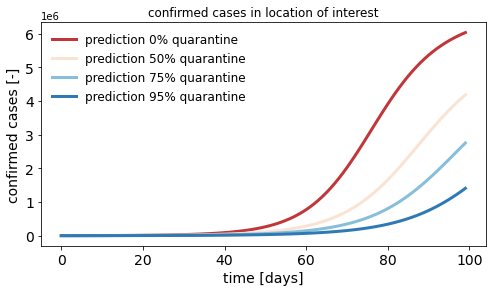

In [91]:
#%% ################### Plot results #######################################

t = np.arange(0,Tmax, dt)
days = np.arange(0,Tmax, 1)
skip = int(1/dt)

# color palette
Color_p = sns.color_palette("RdBu", 6)

fig, ax1 = plt.subplots(figsize=(500/72,300/72))


ax1.plot(days, confirmed[::skip],color = Color_p[0],lw=3,zorder=1, label=r'prediction 0% quarantine') # 
ax1.plot(days, confirmed_50[::skip],color = Color_p[2],lw=3,zorder=1, label=r'prediction 50% quarantine') #
ax1.plot(days, confirmed_75[::skip],color = Color_p[4],lw=3,zorder=1, label=r'prediction 75% quarantine') # 
ax1.plot(days, confirmed_95[::skip],color = Color_p[5],lw=3,zorder=1, label=r'prediction 95% quarantine') # 



leg = plt.legend(loc='upper left',fontsize='large',frameon=True)
leg.get_frame().set_linewidth(0.0)

ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

plt.ylabel('confirmed cases [-]',fontsize=14)
plt.xlabel('time [days]',fontsize=14)
plt.title('confirmed cases in location of interest')


plt.tight_layout()

# Tasks

- try switching to a different region of interest (change `idx`). How does the effect of incoming travelers on the disease dynamics change when we are looking at a state with a high population (California, Texas, ...)?

- change `R0_fin` or `fb[idx]` and observe the effect on confirmed cases
- apply quarantine only to high risk travelers (set `Flag_Iso=True`). Do the results change? How?